# Capibal Bike Share

https://capitalbikeshare.com/system-data

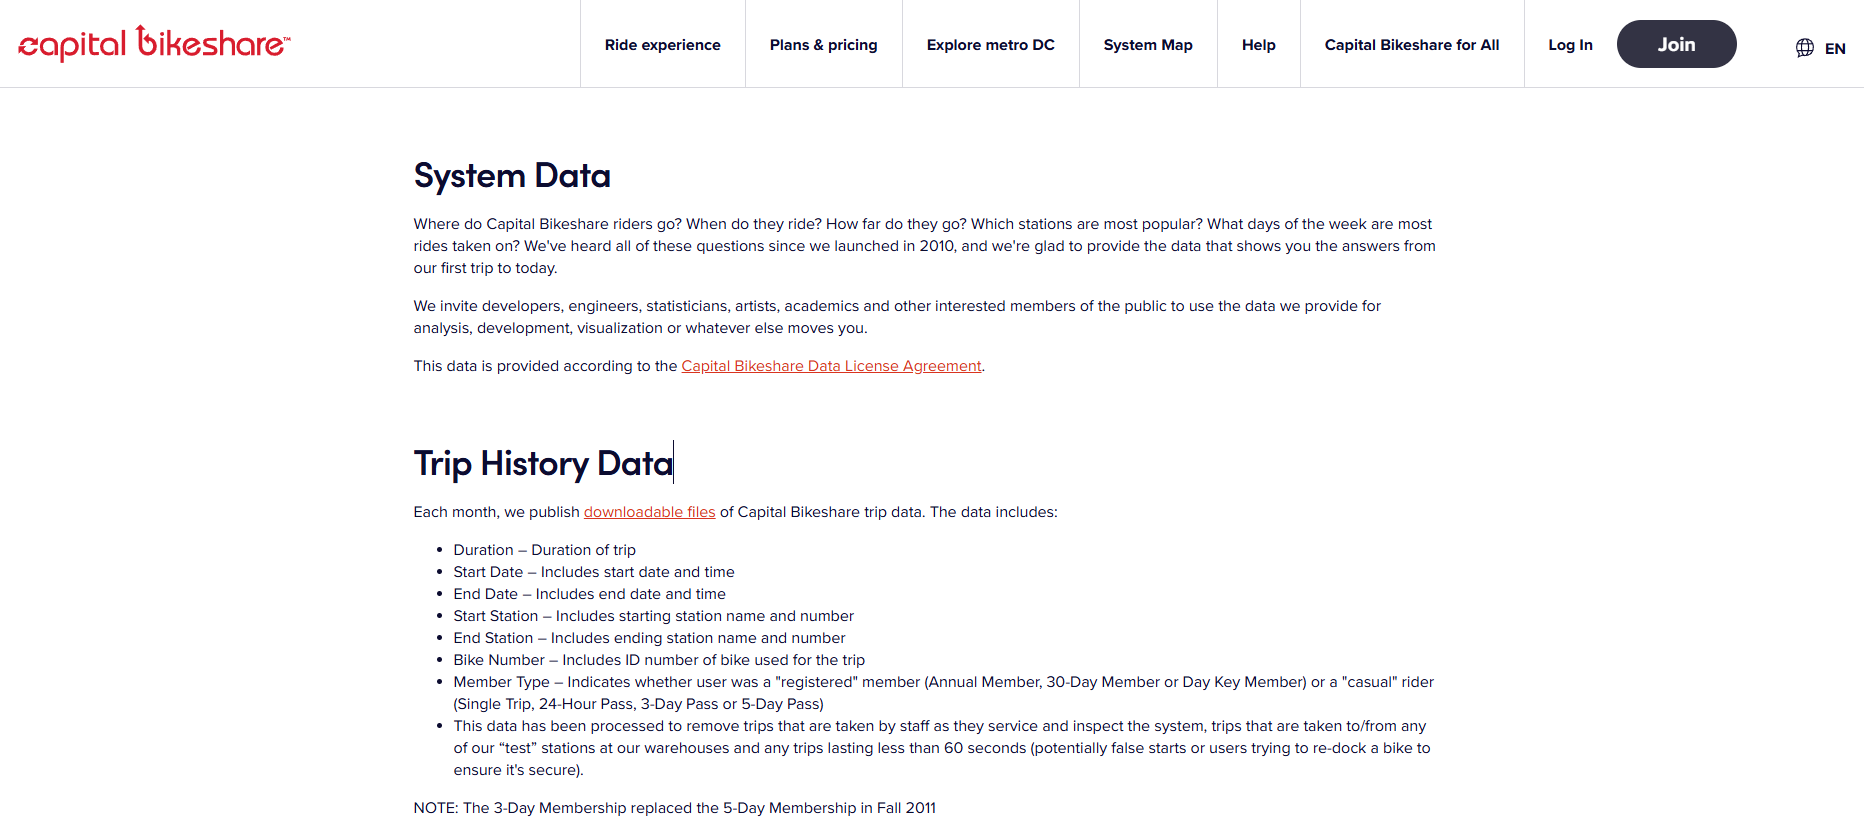

# Forecasting Bike Rental Demand

Bike sharing systems are the new generation of traditional bike rentals where the whole process from membership, rental and return has become automatic. Through these systems, the user can easily rent a bike from a particular position and return back to another area.

We are going to create a neural network and use it to **predict daily bike rentals.**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights.

In [2]:
data_path = 'data/hour.csv'
# Read csv data file using Pandas
rides = pd.read_csv(data_path)

In [3]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
# rides['dteday'] = pd.to_datetime(rides['dteday'])

In [5]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


This dataset has the number of riders for each hour of each day from the 1st of January 2011 to the 31st of December 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. We have information about temperature, humidity, and wind speed, all of this likely affecting the number of riders. The first few rows of the data are shown above.

Below is a plot showing the **number of bike riders over the first ten days** in the data set. You can see the hourly rentals here. We can see that the weekends have lower over all rentals and there are spikes when people are biking to and from work during the week.

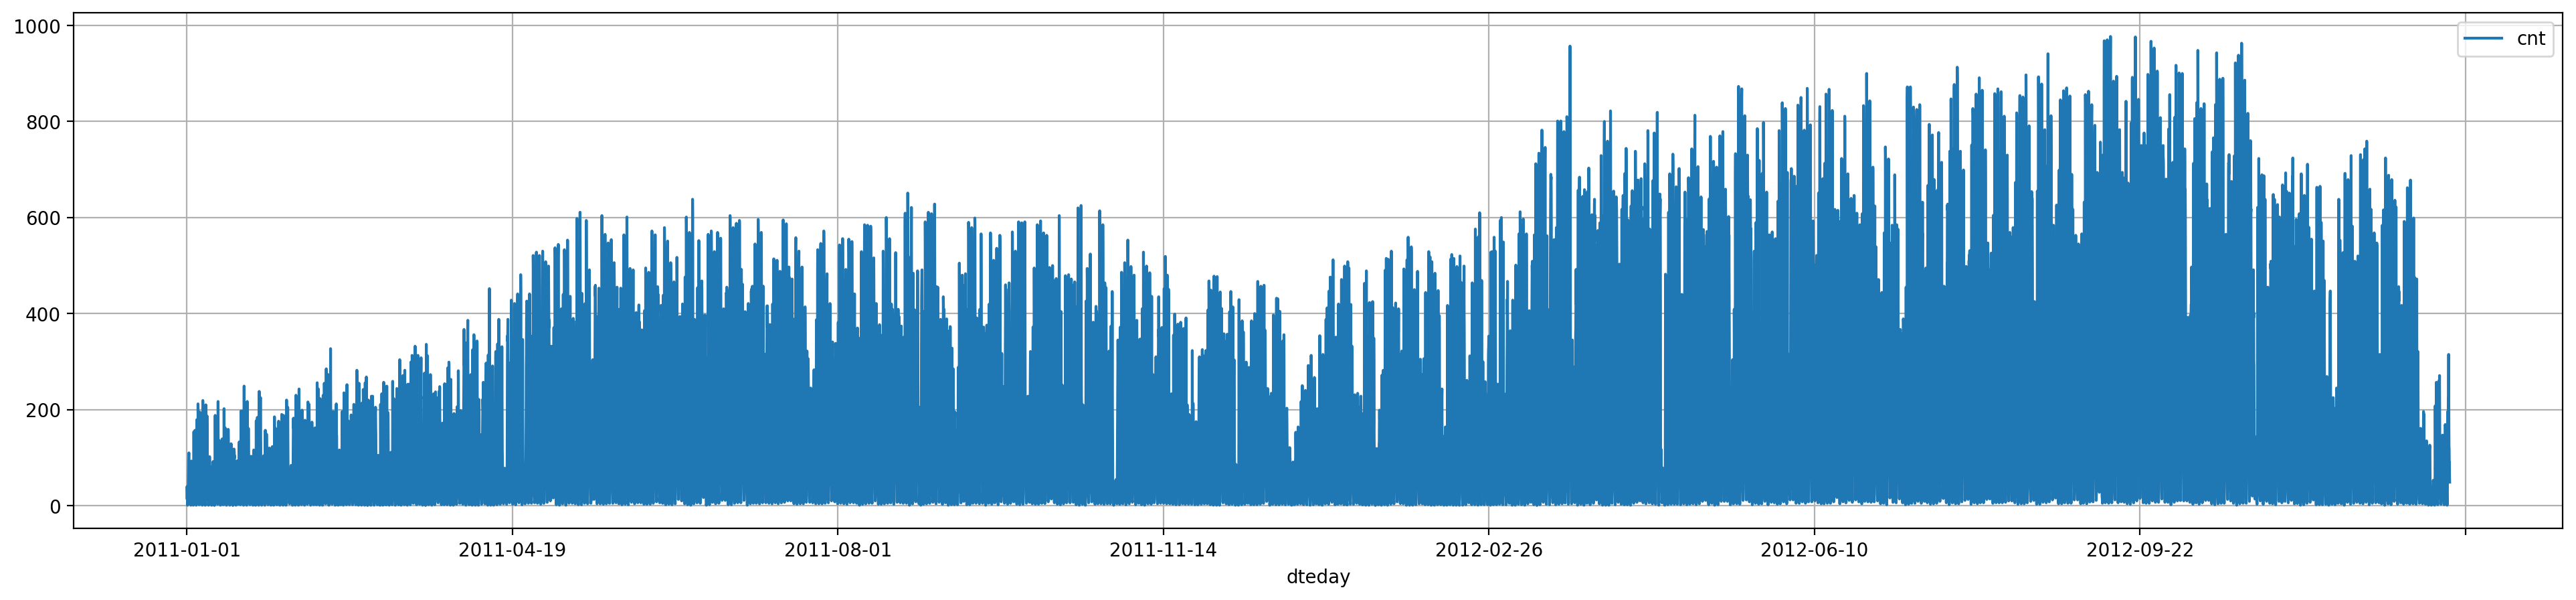

In [6]:
rides[:].plot(x='dteday', y='cnt', figsize=[24,5])
plt.grid()

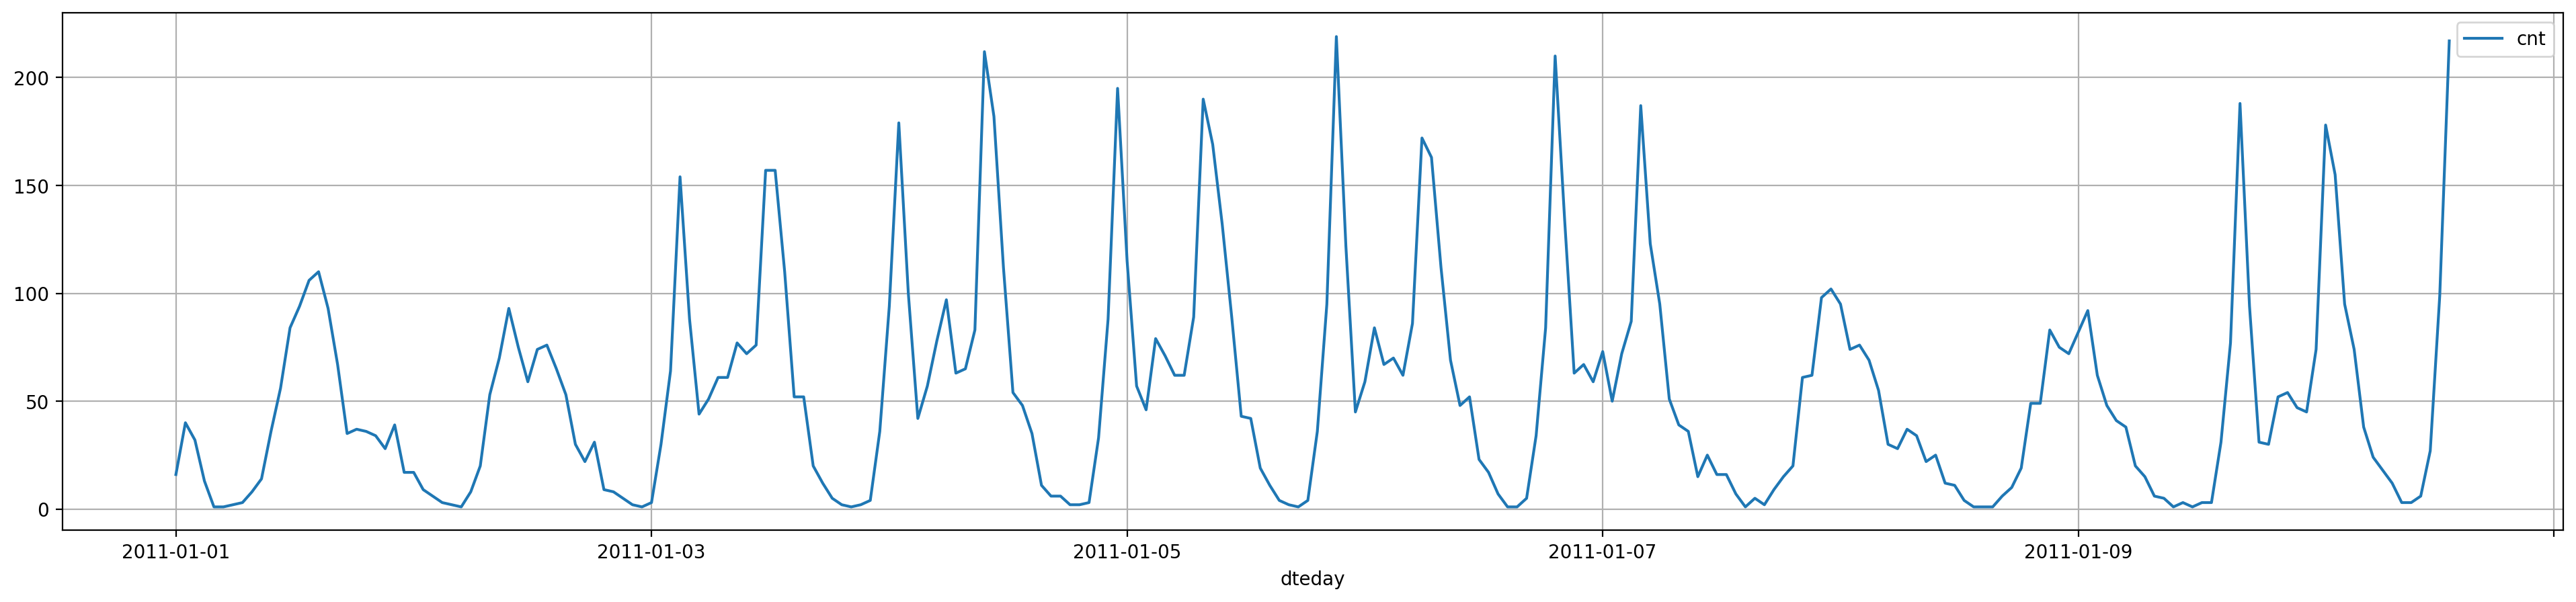

In [7]:
rides[:10*24].plot(x='dteday', y='cnt', figsize=[24,5])
plt.grid()

## Data Examine

In [8]:
rides.nunique().to_frame(name='Unique Values')

,Unique Values
instant,17379
dteday,731
season,4
yr,2
mnth,12
hr,24
holiday,2
weekday,7
workingday,2
weathersit,4


From the above table, we can use some columns with few unique values like "season, mnth, hr, holiday, weekday, workingday, weathersit"

### Splitting the data set

We will save the last 21 days of the data to use as a test set after we've trained the network. We will use this set to make predictions and compare them with the actual number of riders.

In [9]:
# Save the last 21 days 
test_data = rides[pd.to_datetime(rides['dteday']) >= pd.to_datetime('2012-09-01')]
val_data = rides[(pd.to_datetime(rides['dteday']) >= pd.to_datetime('2012-06-01')) & (pd.to_datetime(rides['dteday']) < pd.to_datetime('2012-09-01'))]
train_data = rides[pd.to_datetime(rides['dteday']) < pd.to_datetime('2012-06-01')]

In [10]:
train_data.shape, val_data.shape, test_data.shape

((12283, 17), (2208, 17), (2888, 17))

In [11]:
train_data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12278,12279,2012-05-31,2,1,5,19,0,4,1,1,0.72,0.6515,0.34,0.1642,104,487,591
12279,12280,2012-05-31,2,1,5,20,0,4,1,1,0.68,0.6364,0.44,0.1642,88,391,479
12280,12281,2012-05-31,2,1,5,21,0,4,1,1,0.68,0.6364,0.44,0.1642,41,318,359
12281,12282,2012-05-31,2,1,5,22,0,4,1,1,0.66,0.6212,0.50,0.1642,43,221,264


In [12]:
# Separate the data into features and targets
target_col = 'cnt'
feat_cols = ['season',  'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

We will split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (validation set).

In [13]:
x_train, y_train = train_data[feat_cols], train_data[target_col]
x_val, y_val = val_data[feat_cols], val_data[target_col]
x_test, y_test = test_data[feat_cols], test_data[target_col]

### Transform Feature

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [15]:
cat_cols = ['season',  'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
num_cols = ['temp', 'atemp', 'hum', 'windspeed']

In [16]:
categorical_encoder = OneHotEncoder()
numerical_pipe = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, cat_cols),
        ("num", numerical_pipe, num_cols),
    ],
)

In [17]:
x_train_tf = preprocessor.fit_transform(x_train)
x_val_tf = preprocessor.transform(x_val)
x_test_tf = preprocessor.transform(x_test)

In [18]:
x_train_tf.shape, x_val_tf.shape, x_test_tf.shape

((12283, 59), (2208, 59), (2888, 59))

# Model Training

## Logistic Regression

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
from sklearn.metrics import root_mean_squared_error

In [21]:
lr = LinearRegression()
lr.fit(x_train_tf, y_train)

LinearRegression()

### Evaluate

In [22]:
y_train_pred = lr.predict(x_train_tf)
y_val_pred = lr.predict(x_val_tf)
y_test_pred = lr.predict(x_test_tf)

In [23]:
lr_train_pred_df = pd.DataFrame({
    'dteday': train_data['dteday'],
    'cnt_prediction': y_train_pred
})

lr_val_pred_df = pd.DataFrame({
    'dteday': val_data['dteday'],
    'cnt_prediction': y_val_pred
})

lr_test_pred_df = pd.DataFrame({
    'dteday': test_data['dteday'],
    'cnt_prediction': y_test_pred
})

In [24]:
lr_train_rmse = root_mean_squared_error(y_train, y_train_pred)
lr_val_rmse = root_mean_squared_error(y_val, y_val_pred)
lr_test_rmse = root_mean_squared_error(y_test, y_test_pred)
lr_train_rmse, lr_val_rmse, lr_test_rmse

(91.26203142098105, 167.94462007872673, 159.653966574778)

<function matplotlib.pyplot.show(close=None, block=None)>

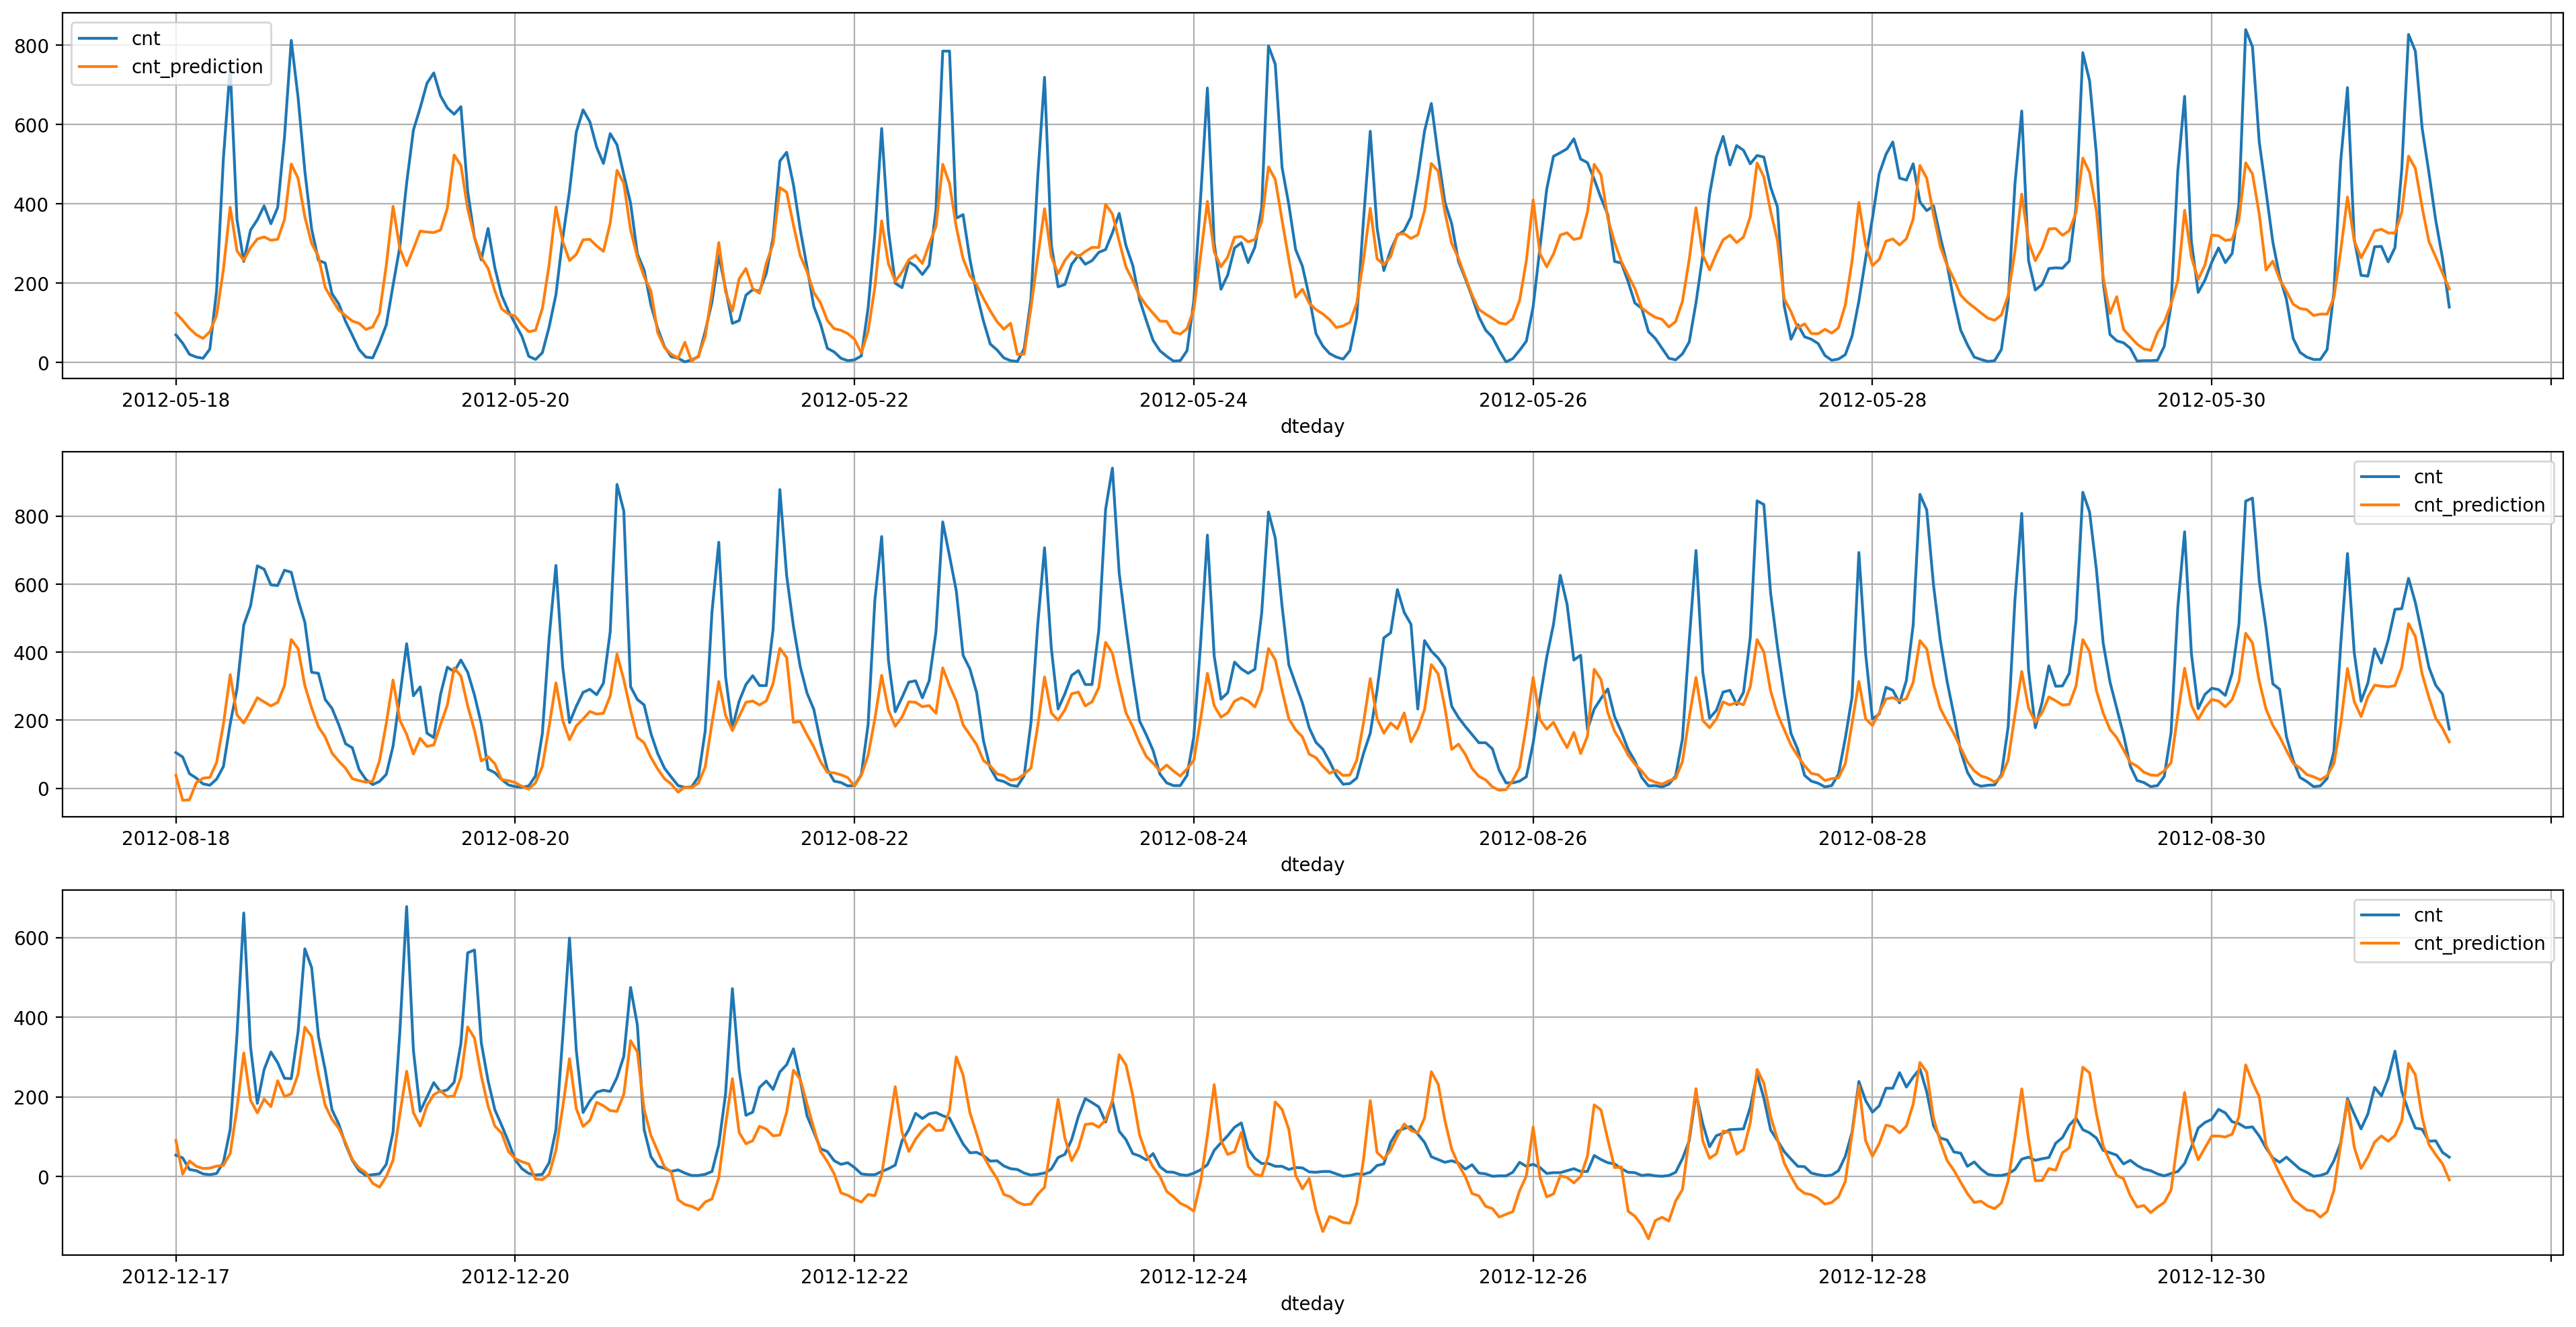

In [25]:
fig, ax = plt.subplots(3,1, figsize=(24,12))

train_data[-24*14:].plot(x='dteday', y='cnt', ax=ax[0])
lr_train_pred_df[-24*14:].plot(x='dteday', y='cnt_prediction', ax=ax[0])

val_data[-24*14:].plot(x='dteday', y='cnt', ax=ax[1])
lr_val_pred_df[-24*14:].plot(x='dteday', y='cnt_prediction', ax=ax[1])

test_data[-24*14:].plot(x='dteday', y='cnt', ax=ax[2])
lr_test_pred_df[-24*14:].plot(x='dteday', y='cnt_prediction', ax=ax[2])

ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show

## Neural network 1

In [26]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig, GANDALFConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig
from pytorch_tabular.models import GANDALFConfig

In [27]:
data_config = DataConfig(
    target=[
        target_col
    ],  # target should always be a list
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
    normalize_continuous_features=True,
    continuous_feature_transform="quantile_normal",

)
trainer_config = TrainerConfig(
    batch_size=1024,
    max_epochs=300,
    early_stopping=None,
)
optimizer_config = OptimizerConfig(
    optimizer="torch_optimizer.QHAdam",
    optimizer_params={"nus": (0.7, 1.0), "betas": (0.95, 0.998)},
    lr_scheduler="CosineAnnealingWarmRestarts",
    lr_scheduler_params={"T_0": 10, "T_mult": 1, "eta_min": 1e-5},
)

In [28]:
head_config = LinearHeadConfig(
    layers="",  # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming",
).__dict__  # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

model_config = CategoryEmbeddingModelConfig(
    task="regression",
    layers="64-32-16",
    activation="LeakyReLU",
    dropout=0.1,
    initialization="kaiming",
    head="LinearHead",  # Linear Head
    head_config=head_config,  # Linear Head Config
    learning_rate=1e-3,
    target_range= [(float(train_data[target_col].min()),float(train_data[target_col].max()))]
)

In [29]:
from pytorch_tabular import TabularModel

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2024-09-29 16:44:55,965 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

In [30]:
tabular_model.fit(train=train_data, validation=val_data)

Epoch 299/299 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:00:00 • 0:00:00 17.60it/s v_num: 6.000 train_loss: 2552.163 
                                                                                 valid_loss: 14794.601             
                                                                                 valid_mean_squared_error:         
                                                                                 14794.601                         
                                                                                 train_mean_squared_error: 2669.327

`Trainer.fit` stopped: `max_epochs=300` reached.


2024-09-29 16:49:02,508 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-09-29 16:49:02,511 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

C:\Users\ADMINS\miniconda3\Lib\site-packages\pytorch_tabular\utils\python_utils.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=map_lo

### Evaluation

In [31]:
nn_train_pred_df = tabular_model.predict(train_data)
train_result = tabular_model.evaluate(train_data)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:00:00 • 0:00:00 23.50it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2157.093994140625     │
│  test_mean_squared_error  │     2157.093994140625     │
└───────────────────────────┴───────────────────────────┘

In [32]:
nn_val_pred_df = tabular_model.predict(val_data)
val_result = tabular_model.evaluate(val_data)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 0:00:00 • 0:00:00 32.26it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      13989.05859375       │
│  test_mean_squared_error  │      13989.05859375       │
└───────────────────────────┴───────────────────────────┘

In [33]:
nn_test_pred_df = tabular_model.predict(test_data)
test_result = tabular_model.evaluate(test_data)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 0:00:00 • 0:00:00 25.64it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      13919.615234375      │
│  test_mean_squared_error  │      13919.615234375      │
└───────────────────────────┴───────────────────────────┘

C:\Users\ADMINS\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


In [34]:
nn_train_pred_df['dteday'] = train_data['dteday']
nn_val_pred_df['dteday'] = val_data['dteday']
nn_test_pred_df['dteday'] = test_data['dteday']

<function matplotlib.pyplot.show(close=None, block=None)>

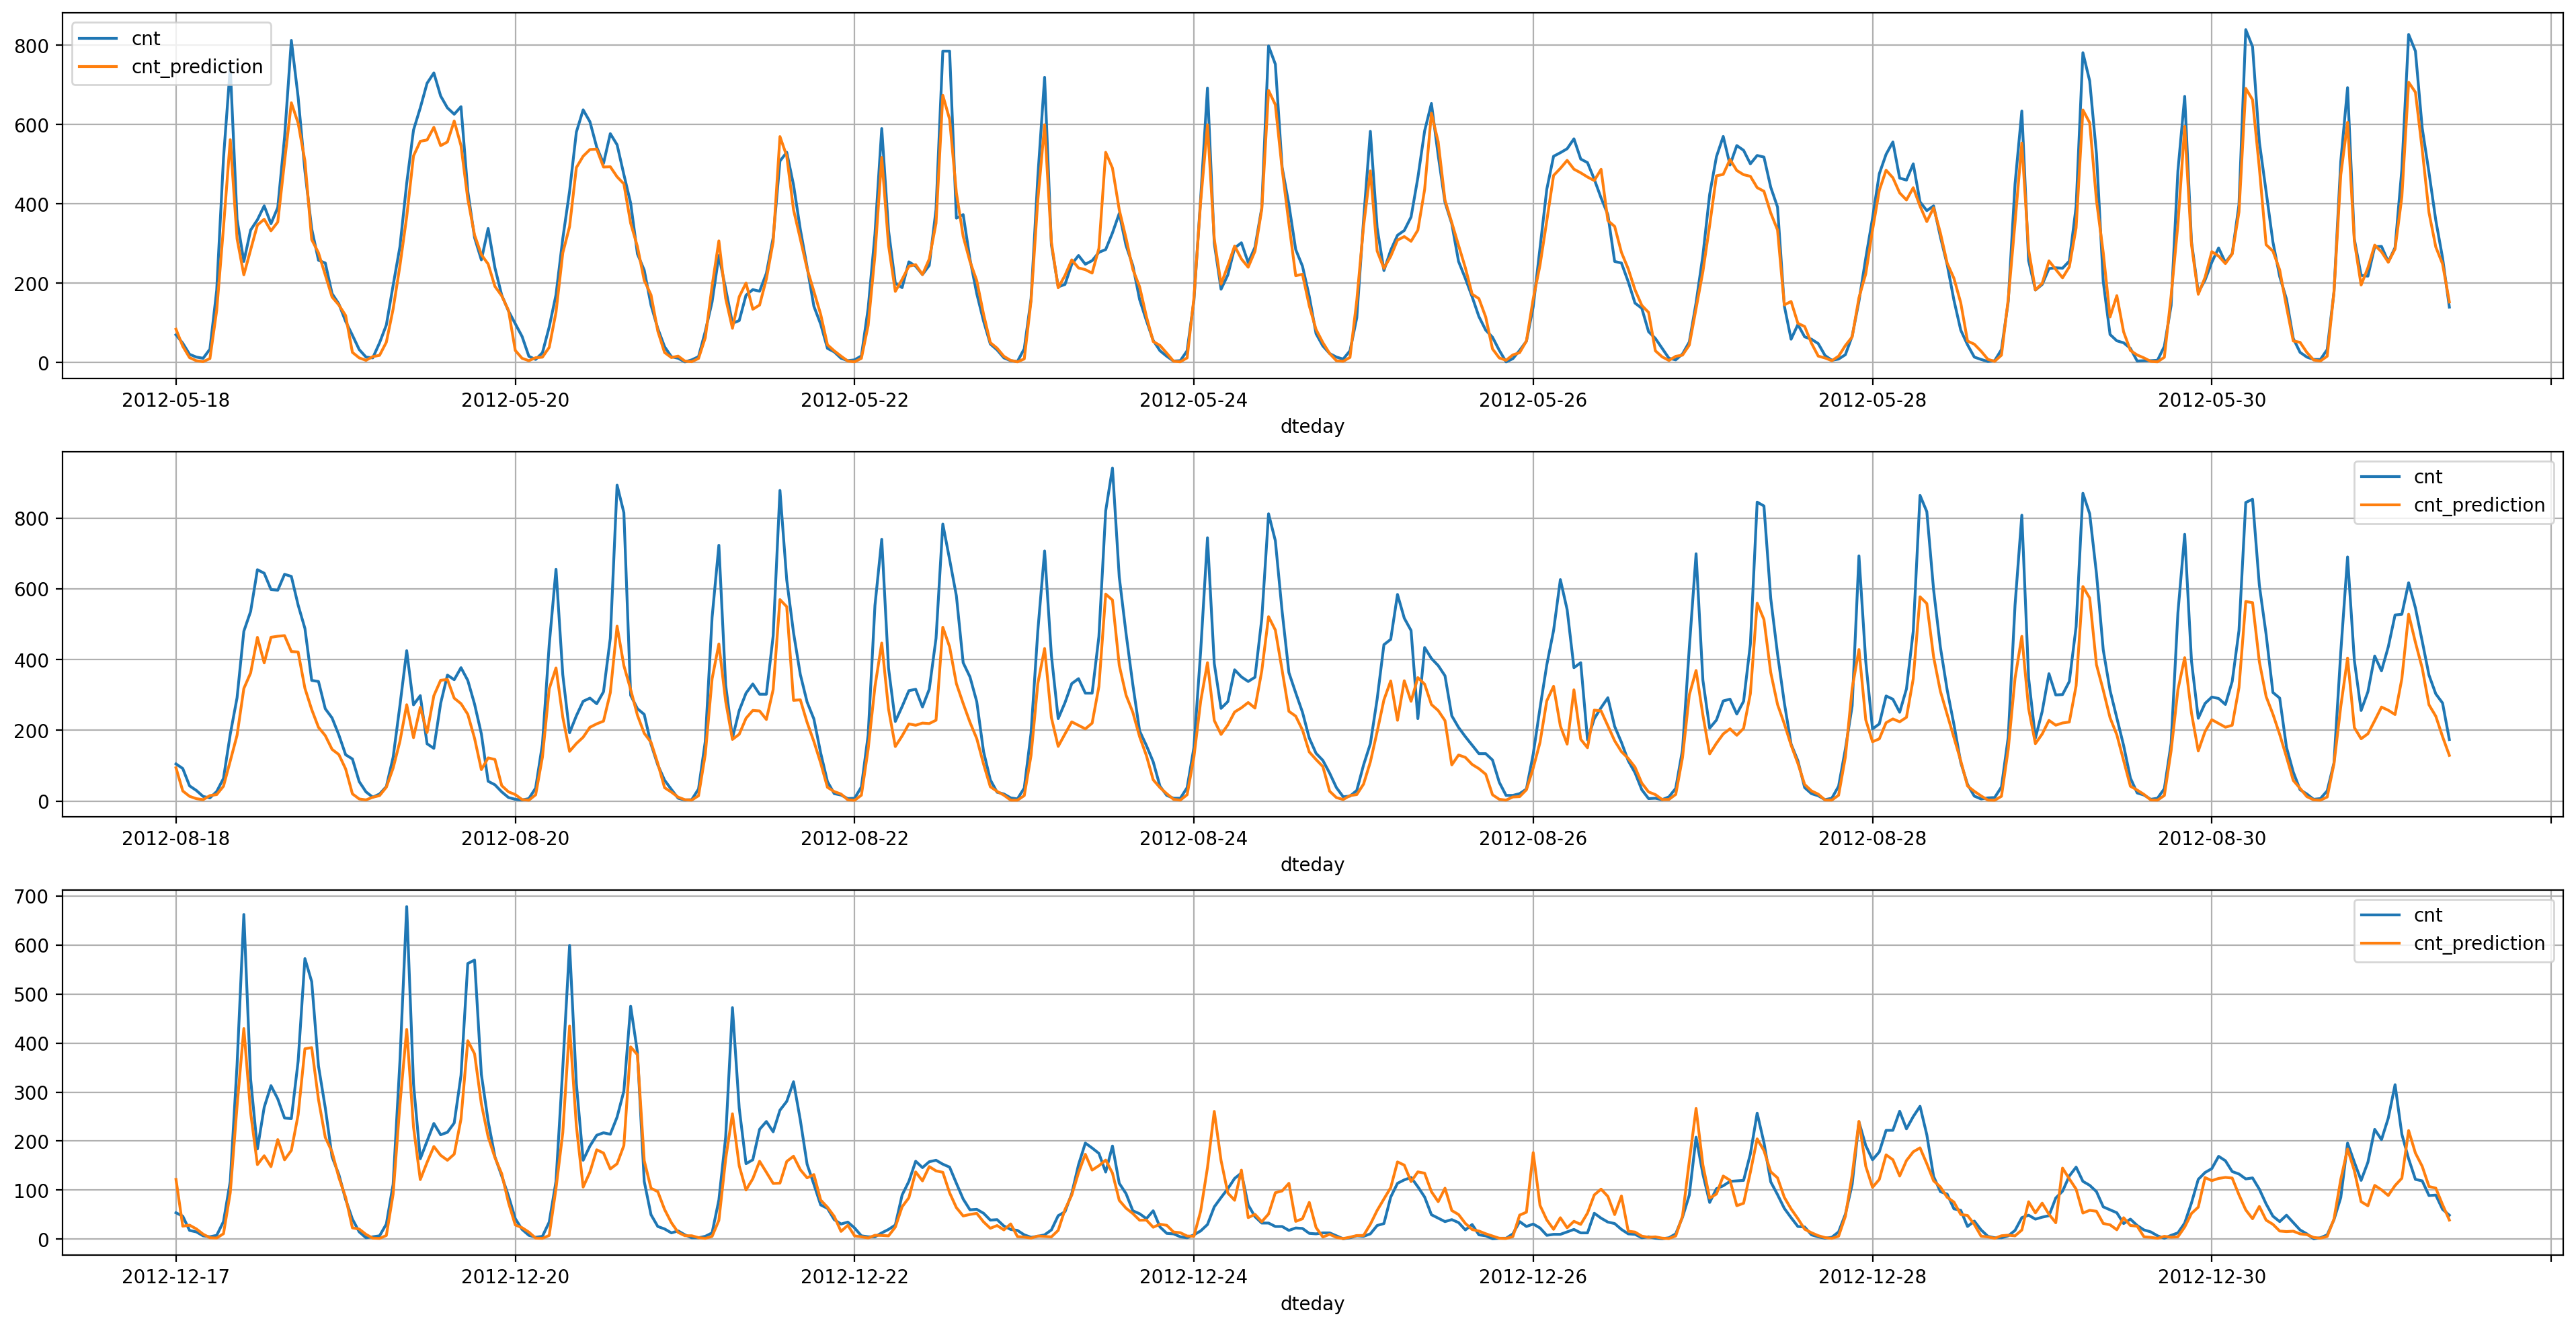

In [35]:
fig, ax = plt.subplots(3,1, figsize=(24,12))

train_data[-24*14:].plot(x='dteday', y='cnt', ax=ax[0])
nn_train_pred_df[-24*14:].plot(x='dteday', y='cnt_prediction', ax=ax[0])

val_data[-24*14:].plot(x='dteday', y='cnt', ax=ax[1])
nn_val_pred_df[-24*14:].plot(x='dteday', y='cnt_prediction', ax=ax[1])

test_data[-24*14:].plot(x='dteday', y='cnt', ax=ax[2])
nn_test_pred_df[-24*14:].plot(x='dteday', y='cnt_prediction', ax=ax[2])

ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show

## Compare 2 models

In [36]:
lr_test_rmse, np.sqrt(test_result[0]['test_mean_squared_error'])

(159.653966574778, 117.98141902170443)

<function matplotlib.pyplot.show(close=None, block=None)>

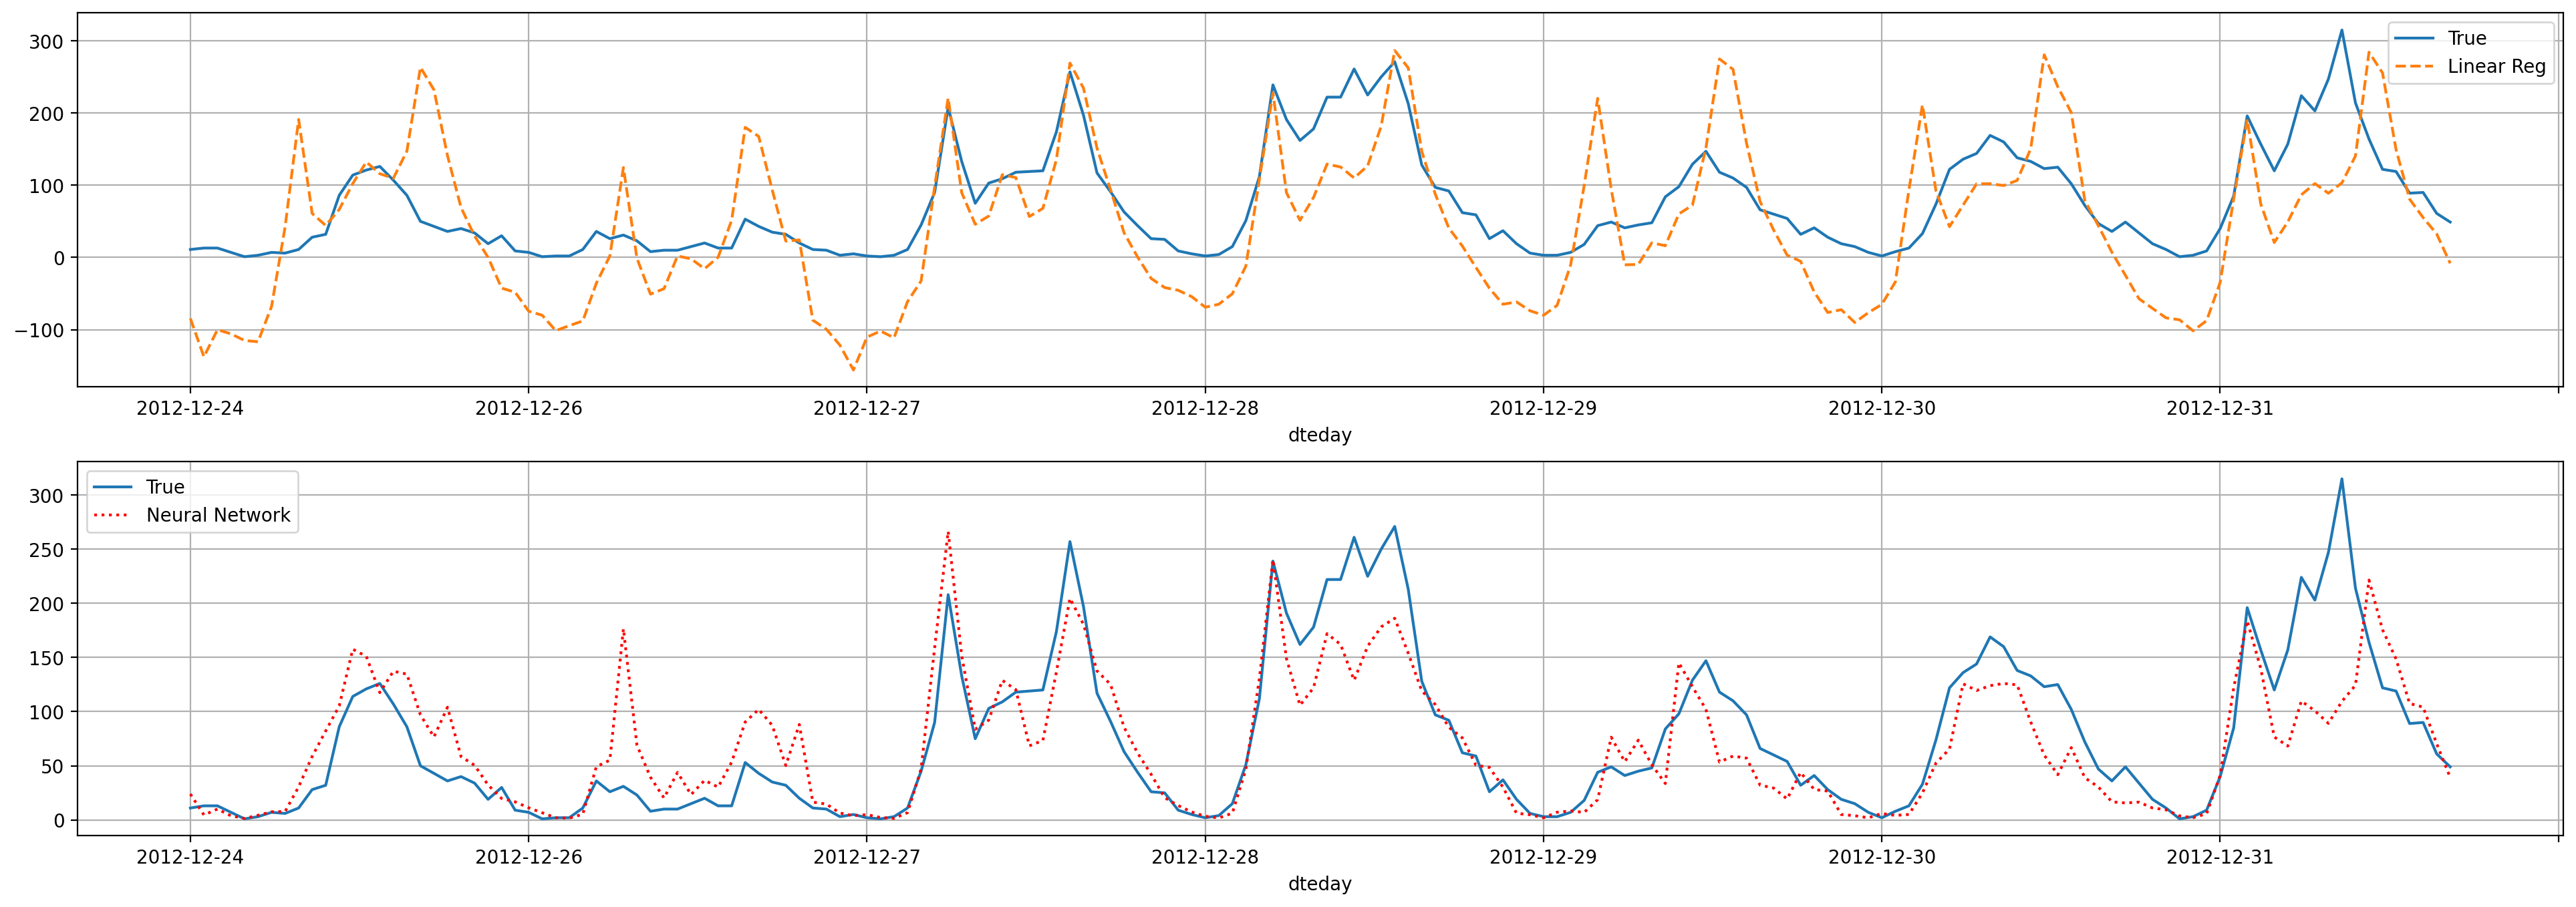

In [37]:
fig, ax = plt.subplots(2,1, figsize=(24,8))

test_data[-24*7:].plot(x='dteday', y='cnt',label='True', ax=ax[0])
lr_test_pred_df[-24*7:].plot(x='dteday', y='cnt_prediction', label='Linear Reg', linestyle='--', ax=ax[0])

test_data[-24*7:].plot(x='dteday', y='cnt',label='True', ax=ax[1])
nn_test_pred_df[-24*7:].plot(x='dteday', y='cnt_prediction', label='Neural Network', linestyle=':', ax=ax[1], color='red')
ax[0].grid()
ax[1].grid()
plt.show